# Final Project - Predicting Movie Genres!

![Movie genre header](genre_header.jpg)

Welcome to the final project of CS109b. 

The overall theme of the final project is movie data with a focus on movie genre prediction, because it is an area where we all are more or less application domain experts. First, you will explore your data and the challenges of the problem by exploratory data analysis. Use visualizations to find features that correlate with movie genres. These can be extracted from the movie posters, or meta data, or other data you gather, for example plot summaries or even movie transcripts. You will then compare traditional statistical or machine learning methods like generalized additive models, random forest, Bayesian prediction methods, boosting, and SVM, to deep learning models for movie genre prediction. 

For this project you will work in teams of 3-4 people and there are weekly milestones to guide you along the way. Even though the milestones are graded, they are mainly in place to make sure you stay in contact with your TF and make progress with the project. Throughout the project you also have room for creativity and to pursue your own ideas. While you need to hand in the milestones at the appropriate due date, there is nothing preventing you from working on a later milestone ahead of time. We suggest that you read through the whole project and all milestones in the beginning to be able to plan ahead. The project is pretty open ended, so you can be creative and let your data science knowledge shine! 

For each milestone you will submit a notebook, in raw (`.ipynb`) and PDF formats, containing the deliverables of that week and the extra work you did so far. The notebooks need to contain your code, comments, explanations, thoughts, and visualizations. The final deliverables are a two-minute screencast, a report in paper style for a general data science audience, and all your data and code that you developed throughout the project. 

Below is a description of the data and the milestones with their due dates. All work is due by 11:59PM on the due date unless otherwise specified. We expect you to have the mandatory parts finished by the milestone due dates, and there will be no extensions. However, we strongly encourage you to plan ahead. For example, you need to think about the classification task early on to plan how you want to assemble your training data, and it is beneficial to start the deep learning work as early as possible. There is nothing hindering you to already train a model in the EDA phase to get a better feel for what challenges might lay ahead with the data. You should also see the milestone requirements as a basis for your own creativity, and we expect that most of you will go beyond the mandatory deliverables. For example, if you have a great idea about an interesting question that has to do with movie genre, but cannot be answered with the data from TMDb or IMDb, feel free to gather more data from somewhere else. 

We provide a data interface in Python, because it is convenient for IMDb, and we will use Python for the deep learning part. Specifically we will use Keras, a deep learning library that provides a high level interface to Google's Tensorflow framework for deep learning. However, if you feel that you prefer to do some of the work, e.g., visualizations or data cleanup, in R then feel free to use it. You can also use Spark to preprocess your data, especially if you collect large amounts of it from other sources. 

*Important:* Your grade for a milestone will depend on the required deliverables you submit at the due date for that milestone. But every milestone, especially the final project submission, can contain additional cool work you did that goes beyond the deliverables spelled out below. 


### Milestone 2: Assembling training data, due Wednesday, April 12, 2017

We are aware that you have little time this week, due to the midterm. So this milestone a bit easier to achieve than the others. The goal for this week is to prepare the data for the modeling phase of the project. You should end up with a typical data setup of training data X and data labels Y.

The exact form of X and Y depends on the ideas you had previously. In general though Y should involve the genre of a movie, and X the features you want to include to predict the genre. Remember from the lecture that more features does not necessarily equal better prediction performance. Use your application knowledge and the insight you gathered from your genre pair analysis and additional EDA to design Y. Do you want to include all genres? Are there genres that you assume to be easier to separate than others? Are there genres that could be grouped together? There is no one right answer here. We are looking for your insight, so be sure to describe your decision process in your notebook. 

In preparation for the deep learning part we strongly encourage you to have two sets of training data X, one with the metadata and one with the movie posters. Make sure to have a common key, like the movie ID, to be able to link the two sets together. Also be mindful of the data rate when you obtain the posters. Time your requests and choose which poster resolution you need. In most cases w500 should be sufficient, and probably a lower resolution will be fine.

The notebook to submit this week should at least include:

- Discussion about the imbalanced nature of the data and how you want to address it
- Description of your data
- What does your choice of Y look like?
- Which features do you choose for X and why? 
- How do you sample your data, how many samples, and why?

*Important*: You do not need to upload the data itself to Canvas.

In [1]:
import time
import random
import pickle
import urllib
import csv
import logging
from IPython.display import Image
from IPython.core.display import HTML 
from requests import HTTPError
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import OrderedDict
from operator import itemgetter

In [2]:
#bring in the data
movie_df112 = pd.read_csv('Milestone_1/tmdb_movies_11291.csv', names = [
    'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id',
    'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies',
    'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
    'video', 'vote_average', 'vote_count',
])

### Discussion about the imbalanced nature of the data and how you want to address it

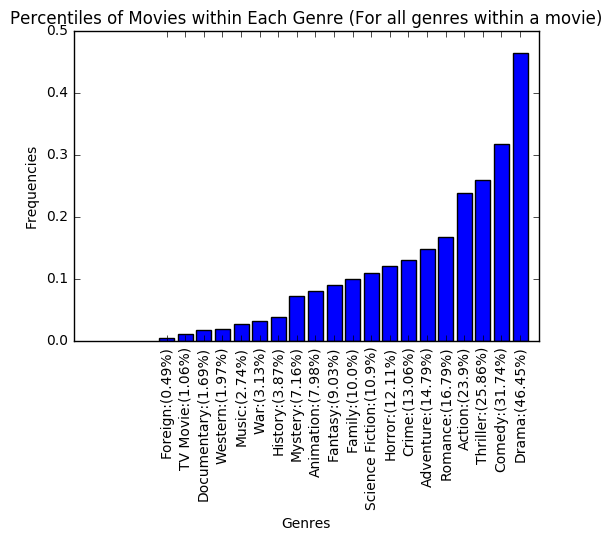

In [3]:
#Here we can focus on the imbalances of each class
def genre_clean(df):
    genres = []
    all_genre = []
    for row in df['genres'].tolist():
        cur_row = []
        for entry in ast.literal_eval(row):
            cur_row.append(str(entry[u'name']))
            all_genre.append(str(entry[u'name']))
        genres.append(' '.join(cur_row))
    return (genres, list(set(all_genre)))

def create_dic_and_plot(df, every_genre, ds = ''):
    freq_dic = {}
    for genre in every_genre:
        temp = float(len(df[df['genre_vals'].str.contains(genre)]))/float(len(df))
        key = genre + ':(' + str(round(temp, 4)*100) + '%)'
        freq_dic[key] = temp
    new = OrderedDict(sorted(freq_dic.items(), key=itemgetter(1)))
    
    plt.bar(range(len(new)), new.values(), align='center', color= 'blue')
    plt.xticks(range(len(new)), new.keys(), rotation=90)
    plt.ylabel('Frequencies')
    plt.xlabel('Genres')
    plt.title('Percentiles of Movies within Each Genre (For all genres within a movie)'+ds)
    plt.show()
genre_meta = genre_clean(movie_df112)
movie_df112['genre_vals'] = genre_meta[0]
create_dic_and_plot(movie_df112, genre_meta[1], '')

As one can see, drama is used as a label on a whopping 46.45% of movie labels

In [4]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return pickle.load(handle)

In [5]:
master_dict = load_part('data/tmdb_info.pickle')

In [26]:
imdb_dict = load_part('data/imdb_info.pickle')

In [6]:
with open('data/movie_info.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['movie_id', 'release_date', 'budget', 'revenue',  'genre', 'cast'])
    for movie_id, movie in master_dict.iteritems():
        for genre in movie.genres:
            writer.writerow([movie_id, 
                 movie.release_date, 
                 movie.budget, 
                 movie.revenue, 
                 genre['name'],
                u'|'.join([c['name'] for c in movie.cast]).encode('utf-8').strip()                            
            ])

In [7]:
df = pd.DataFrame.from_csv('data/movie_info.csv')

In [8]:
df['release_date'] = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].dt.year
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] =  df['revenue'].replace(0, np.nan)

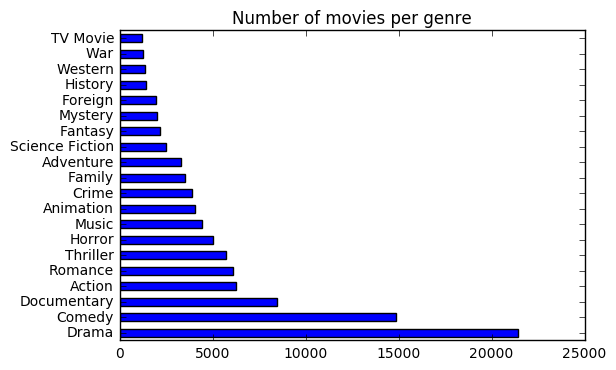

In [9]:
df['genre'].value_counts().plot(kind="barh", title = 'Number of movies per genre')
plt.show()

From here, our discussion can focus on the ways to account for class imbalance when creating our model (via class weights), or we can go into our discussion of reformatting the multi class system.

In [10]:
#back to the other dataset
print movie_df112['genre_vals'].value_counts()
print len(movie_df112['genre_vals'].value_counts())
#here we can see that things like drama and romance or comedy and drama over represent classes
#also a problem that there are 2109 unique combinations of genre, many with only 1 observation

Drama                                               917
Comedy                                              698
Drama Romance                                       392
Comedy Drama                                        276
Comedy Romance                                      256
Horror Thriller                                     211
Comedy Drama Romance                                209
Horror                                              204
Drama Thriller                                      162
                                                    151
Thriller                                            122
Documentary                                         120
Drama Comedy                                        113
Action Thriller                                     107
Animation Family                                    100
Crime Drama                                          96
Crime Drama Thriller                                 95
Action                                          

### Description of your data

#### How we collect the data

We collect data from two sources: TMDB and IMDB.  
The primary source of our data is the TMDB. We collect their full movie object including information about cast and crew. To ensure the sample is random we collect the data in the following way:  
1. Get the id of the latest movie from TMDB.  
2. Generate a random number between 1 and the lartest movie id.  
3. Try to get a movie from TMDB using the random number as movie id.  
4. If failed continue to step 2.
5. Get the movie object back.
6. If the movie obejct does not have valid IMDB id or genres continue to step 2.
6. Update the mobvie object with cast / crew information.  
7. Save the movie object.  
So far we've collected more than 55K TMDB movies with posters. They saved as a dictionary keyed by the TMDB movie id in 'pickle' format.  
The secondary source of data is IMDB. Some of the movies we collect from the TMDB have missing values (budget, cast etc.). We collect those values from the IMDB.
So far we've collected around 10K IMDB movies amd the porcess is ongoing. They also saved as a dictionary keyed by the TMDB movie id in 'pickle' format.  

#### What features we have

In [37]:
tmdb_movie = master_dict[397822]
print 'Features from a TMDB movie object: '
tmdb_movie.__dict__

Features from a TMDB movie object: 


{'adult': False,
 'backdrop_path': None,
 'base_uri': 'https://api.themoviedb.org/3',
 'belongs_to_collection': None,
 'budget': 0,
 'cast': [{u'cast_id': 1,
   u'character': u'Sybille Erler',
   u'credit_id': u'573a4f059251415578000cc8',
   u'id': 1287454,
   u'name': u'Gertrud K\xfcckelmann',
   u'order': 1,
   u'profile_path': None},
  {u'cast_id': 2,
   u'character': u'Jochen Faber',
   u'credit_id': u'573a4f12c3a36806a6000cdb',
   u'id': 18546,
   u'name': u'Hans S\xf6hnker',
   u'order': 2,
   u'profile_path': u'/qjE8uzAwDmDMd8xJquF9Ivu9dTA.jpg'},
  {u'cast_id': 3,
   u'character': u'Elisabeth Faber',
   u'credit_id': u'573a4f2192514173d7000931',
   u'id': 1090603,
   u'name': u'Antje Weisgerber',
   u'order': 3,
   u'profile_path': u'/b5aYpopOsMm8ZuMrGbniKaB5UrX.jpg'},
  {u'cast_id': 4,
   u'character': u'Draaden',
   u'credit_id': u'573a4f309251415578000ccf',
   u'id': 13377,
   u'name': u'Paul Henckels',
   u'order': 4,
   u'profile_path': u'/zhobicq3xGKwQed7jddckd0sjHl.jpg'},

The poster images saved locally as JPEG files, the file name is the movie id plus '.jpg' extension.

In [25]:
Image(url= 'posters/' + str(tmdb_movie.id) + '.jpg')

In [36]:
imdb_movie = imdb_dict[270368]
print 'Features from a IMDB movie object: '
imdb_movie.items()

Features from a IMDB movie object: 


[('rating', 7.8),
 ('camera and electrical department',
  [<Person id:0662953[http] name:_Parks, Gordon_>]),
 ('producer',
  [<Person id:0514156[http] name:_Liss, Abe_>,
   <Person id:6970759[http] name:_Magdoff, Sam_>]),
 (u'distributors', [<Company id:0512350[http] name:_Contemporary Films_>]),
 ('title', u'Flavio'),
 ('genres', [u'Documentary', u'Short']),
 ('writer', [<Person id:0662953[http] name:_Parks, Gordon_>]),
 ('votes', 5),
 ('kind', u'movie'),
 ('runtimes', [u'12']),
 ('director', [<Person id:0662953[http] name:_Parks, Gordon_>]),
 ('cast',
  [<Person id:0196239[http] name:_da Silva, Flavio_>,
   <Person id:6970758[http] name:_Martinez, Peter_>]),
 ('editor', [<Person id:1478240[http] name:_Gittler, Allan_>]),
 ('year', 1964),
 ('original music', [<Person id:0839657[http] name:_Suriñac, Carlos_>]),
 ('countries', [u'USA']),
 (u'production companies',
  [<Company id:0512349[http] name:_Elektra Studios_>]),
 ('color info', [u'Black and White']),
 ('country codes', [u'us']),


### What does your choice of Y look like?

### Which features do you choose for X and why?

Here I think it would be great to really hone in on what our feature set will look like. I am a big fan of the textual analysis, movie poster image recognition and then the feature set we have with the inherent database.

In [12]:
#inate feature set (budget, revenue, length, box office, director, ratings, voting)

In [13]:
#textual analysis, here it would be great to bring
#in a script or script database and do preliminary analysis of differences in scripts among genres
#http://www.imsdb.com/
#https://github.com/AnnaVM/Project_Plotline/blob/master/code/scraping_script.py

In [14]:
#lastly, we can intro our poster image database and write a few notes as to how we would reduce the feature set via PCA
#I will implement a basic PCA on one of the images to show the reduction of the pixel feature set

### How do you sample your data, how many samples, and why?